#### ****Reaction Wheel****

#### ***Import Dependencies***

In [17]:
!pip install --upgrade matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.9.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 259.7 kB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.3
    Uninstalling matplotlib-3.8.3:
      Successfully uninstalled matplotlib-3.8.3


In [26]:
import os
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env


Bad key axes3d.automargin in file /Users/mohana25/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle, line 227 ('axes3d.automargin   : False   # automatically add margin when manually setting 3D axis limits')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


#### ***Load Environment***

In [34]:
#Create a custom Env
class ReactionWheelPendulumEnv(gym.Env):
    def __init__(self):
        self.gravity = 9.81 #m/s^2
        self.length = 1.0  # m
        self.mass = 1.0  # kg
        self.inertia = 0.1  # kg m^2
        self.reaction_wheel_inertia = 0.01  # kg m^2
        self.max_angle = 30 * np.pi / 180  # rad
        self.max_angular_velocity = 10 * np.pi / 180  # rad/s
        self.max_reaction_wheel_angular_velocity = 50 * np.pi / 180  # rad/s
        self.dt = 0.01  # s

        self.state_dim = 3
        self.action_dim = 1

        self.state = np.zeros(self.state_dim)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_dim,))

    def reset(self):
        self.state = np.random.uniform(low=-self.max_angle, high=self.max_angle, size=self.state_dim)
        return self.state

    def step(self, action):
        alpha_rw = action[0]
        theta, omega, omega_rw = self.state

        # Calculate the reaction torque
        tau_rw = self.reaction_wheel_inertia * alpha_rw

        # Calculate the pendulum's angular acceleration
        alpha = (self.gravity * np.sin(theta) - tau_rw) / self.inertia

        # Update the pendulum's state
        omega += alpha * self.dt
        theta += omega * self.dt
        # Update the reaction wheel's state
        omega_rw += alpha_rw * self.dt
        
        # Calculate the reward
        reward = 1 -np.abs(theta) - 0.1 * np.abs(omega)

        # Check for episode termination
        done = np.abs(theta) > self.max_angle or np.abs(omega) > self.max_angular_velocity

        self.state = np.array([theta, omega, omega_rw])
        return self.state, reward, done, {}
    def render(self):   
        theta, omega, omega_rw = self.state
        # Calculate x and y coordinates of the bob based on angle (theta) and length
        x = self.length * np.sin(theta)
        y = -self.length * np.cos(theta)
  
          # Clear previous plot
        plt.cla()
          # Draw pendulum rod and bob
        plt.plot([-self.length, x], [0, y], linewidth=2)
        plt.plot(x, y, 'o', markersize=20)
  
          # Optional: Add elements for reaction wheel visualization
        plt.xlim([-self.length - 0.5, self.length + 0.5])
        plt.ylim([-self.length - 0.5, 0.5])
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Reaction Wheel Pendulum")
  
          # Update plot and pause briefly
        plt.pause(0.001)

#### ***Training our model***

In [41]:
env = ReactionWheelPendulumEnv()

log_path = os.path.join('Training', 'Logs', 'ReactionWheel')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)
model.learn(total_timesteps=50000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to Training/Logs/ReactionWheel/PPO_17
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.9      |
|    ep_rew_mean     | 1.45     |
| time/              |          |
|    fps             | 3781     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.69       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 2441       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00641931 |
|    clip_fraction        | 0.0355     |
|    clip_range           | 

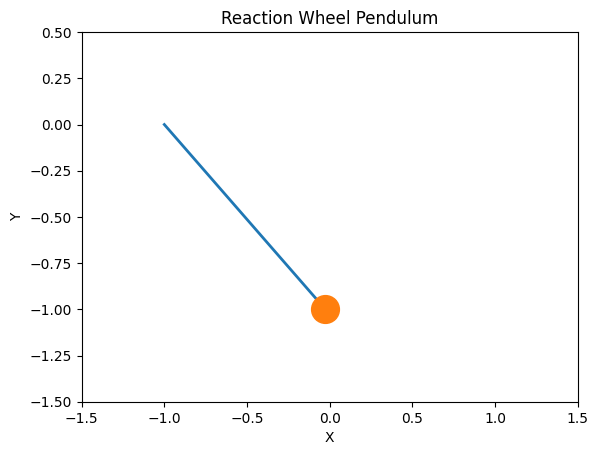

In [42]:
env.render()

#### ***Saving Model***

In [7]:
PPO_path = os.path.join('Training','Saved Models','PPO_Model_ReactionWheelPendulum')

In [8]:
model.save(PPO_path)

#### ***Evaluating Model***

In [43]:
evaluate_policy(model, env, n_eval_episodes = 10, render = True)

(0.9921565413475036, 0.9273439913438379)

In [38]:
env.close()

#### ***Testing Model***

In [44]:
episodes = 5
for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    action_space = env.action_space
    
    while not done :
        action = model.predict(obs)
        temp = env.step(action)
        n_state = temp[0]
        reward = temp[1]
        done = temp[2]
        info = temp[3]
        score += reward
        print("Episode : {}, Score : {}".format(episode, score))

Episode : 1, Score : [0.8394555]
Episode : 2, Score : [0.8165491]
Episode : 3, Score : [0.3800805]
Episode : 4, Score : [0.97241503]
Episode : 5, Score : [0.60651046]


In [40]:
env.close()